# Lab3: split-apply-combine in pandas & data visualization

Question:

Do Netflix subscribers prefer older or newer movies? Are there other factors that affect this preference such as *rating*?

Task:

- Split the dataset into groups, one for each year, and then to compute one or several summary statistics.
- See whether this statistic increases over the years.


Source: https://github.com/datacamp/community-groupby

## Data Exploration with pandas

### Import your data

In [151]:
# Import packages and set visualization style
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

In [82]:
# Import data and check out head of DataFrame
df = pd.read_csv('netflix.csv')
df.head()

,title,rating,ratinglevel,ratingdescription,release_year,user_rating_score,user_rating_size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80


### Data Exploratory Analysis

Applying `pandas` DataFrame `.info()` below shows that you have 1000 rows and 7 columns of data, but also that the column of interest, `user_rating_score`, has only 605 non-null values. This means that there are 395 missing values:

In [24]:
# Check out info of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
title                1000 non-null object
rating               1000 non-null object
ratinglevel          941 non-null object
ratingdescription    1000 non-null int64
release_year         1000 non-null int64
user_rating_score    605 non-null float64
user_rating_size     1000 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


### Dispersion Matrix plot

<IPython.core.display.Javascript object>


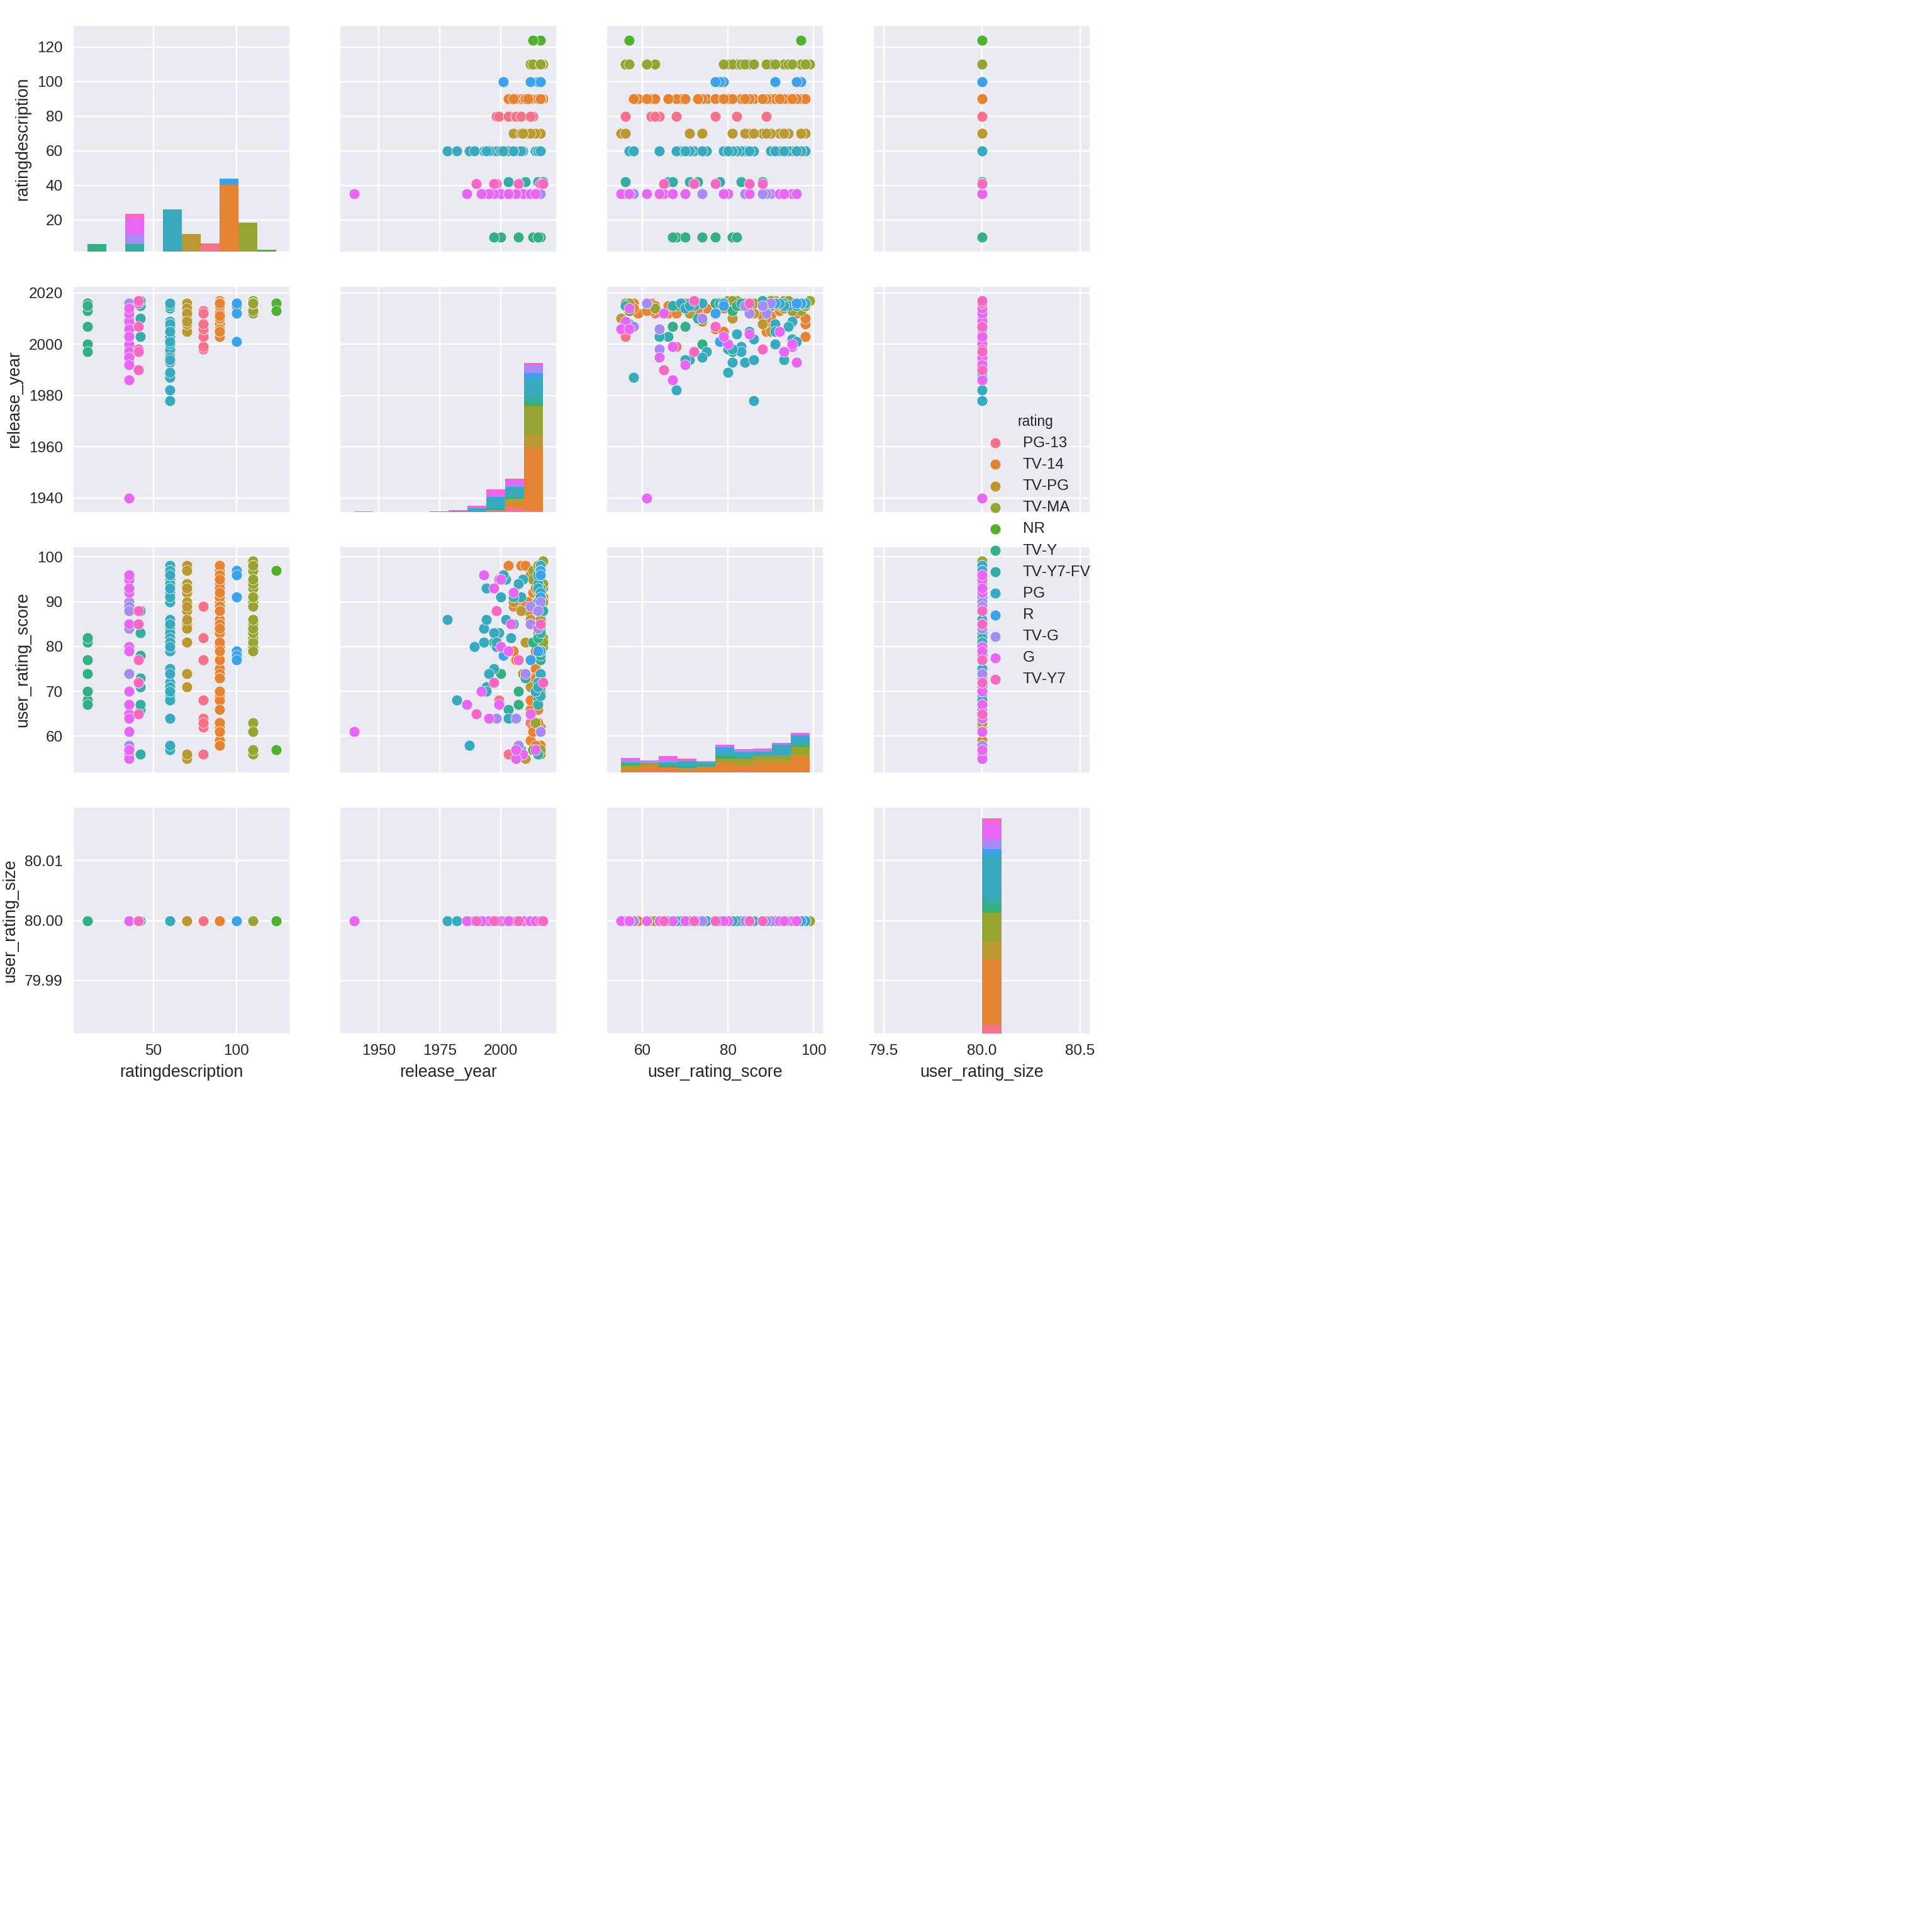

In [84]:
# Drop rows with missing values and drop duplicate
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Visualize pairplot of df (similar to pairs() in R)
sns.pairplot(df, hue='rating');

In [4]:
sns.pairplot?

In [25]:
# Get summary stats of df
df.describe()

,ratingdescription,release_year,user_rating_score,user_rating_size
count,1000.00000,1000.000000,605.000000,1000.000000
mean,67.36600,2010.335000,84.094215,80.783000
std,30.78561,8.877927,12.344371,0.973066
min,10.00000,1940.000000,55.000000,80.000000
25%,35.00000,2007.000000,75.000000,80.000000
50%,60.00000,2015.000000,88.000000,80.000000
75%,90.00000,2016.000000,95.000000,82.000000
max,124.00000,2017.000000,99.000000,82.000000


## Groupby (split-apply-combine) to answer the question

<a id='step_1'></a>

Let us first use a *groupby* method to split the data into groups, where each group is the set of movies released in a given year. 

In [85]:
# Group by year
df_by_year = df.groupby('release_year')

This creates a *groupby* object:

In [86]:
# Check type of GroupBy object
type(df_by_year)

pandas.core.groupby.DataFrameGroupBy

Let us compute summary statistics of our response variable `user_rating_score` in order to capture the main characteristics for each value of `release_year`.

In [87]:
(df.groupby('release_year')
    .describe())

ratingdescription  user_rating_score  user_rating_size
release_year                                                              
1940         count           1.000000           1.000000               1.0
             mean           35.000000          61.000000              80.0
             std                  NaN                NaN               NaN
             min            35.000000          61.000000              80.0
             25%            35.000000          61.000000              80.0
             50%            35.000000          61.000000              80.0
             75%            35.000000          61.000000              80.0
             max            35.000000          61.000000              80.0
1978         count           1.000000           1.000000               1.0
             mean           60.000000          86.000000              80.0
             std                  NaN                NaN               NaN
             min            60.000000          86.000000              80.0
             25%            60.000000          86.000000              80.0
             50%            60.000000          86.000000              80.0
             75%            60.000000          86.000000              80.0
             max            60.000000          86.000000              80.0
1982         count           1.000000           1.000000               1.0
             mean           60.000000          68.000000              80.0
             std                  NaN                NaN               NaN
             min            60.000000          68.000000              80.0
             25%            60.000000          68.000000              80.0
             50%            60.000000          68.000000              80.0
             75%            60.000000          68.000000              80.0
             max            60.000000          68.000000              80.0
1986         count           1.000000           1.000000               1.0
             mean           35.000000          67.000000              80.0
             std                  NaN                NaN               NaN
             min            35.000000          67.000000              80.0
             25%            35.000000          67.000000              80.0
             50%            35.000000          67.000000              80.0
...                               ...                ...               ...
2014         std            21.368874          13.453342               0.0
             min            35.000000          57.000000              80.0
             25%            70.000000          63.000000              80.0
             50%            80.000000          74.000000              80.0
             75%            90.000000          84.000000              80.0
             max           110.000000          94.000000              80.0
2015         count          32.000000          32.000000              32.0
             mean           73.250000          82.750000              80.0
             std            27.344870          11.919082               0.0
             min            10.000000          56.000000              80.0
             25%            60.000000          71.750000              80.0
             50%            80.000000          83.500000              80.0
             75%            90.000000          93.250000              80.0
             max           110.000000          98.000000              80.0
2016         count          82.000000          82.000000              82.0
             mean           84.341463          85.060976              80.0
             std            23.018629          12.221563               0.0
             min            10.000000          56.000000              80.0
             25%            70.000000          77.250000              80.0
             50%            90.000000          90.000000              80.0
             75%           100.000000        

We can depict the above information using a boxplot as follows:

<IPython.core.display.Javascript object>


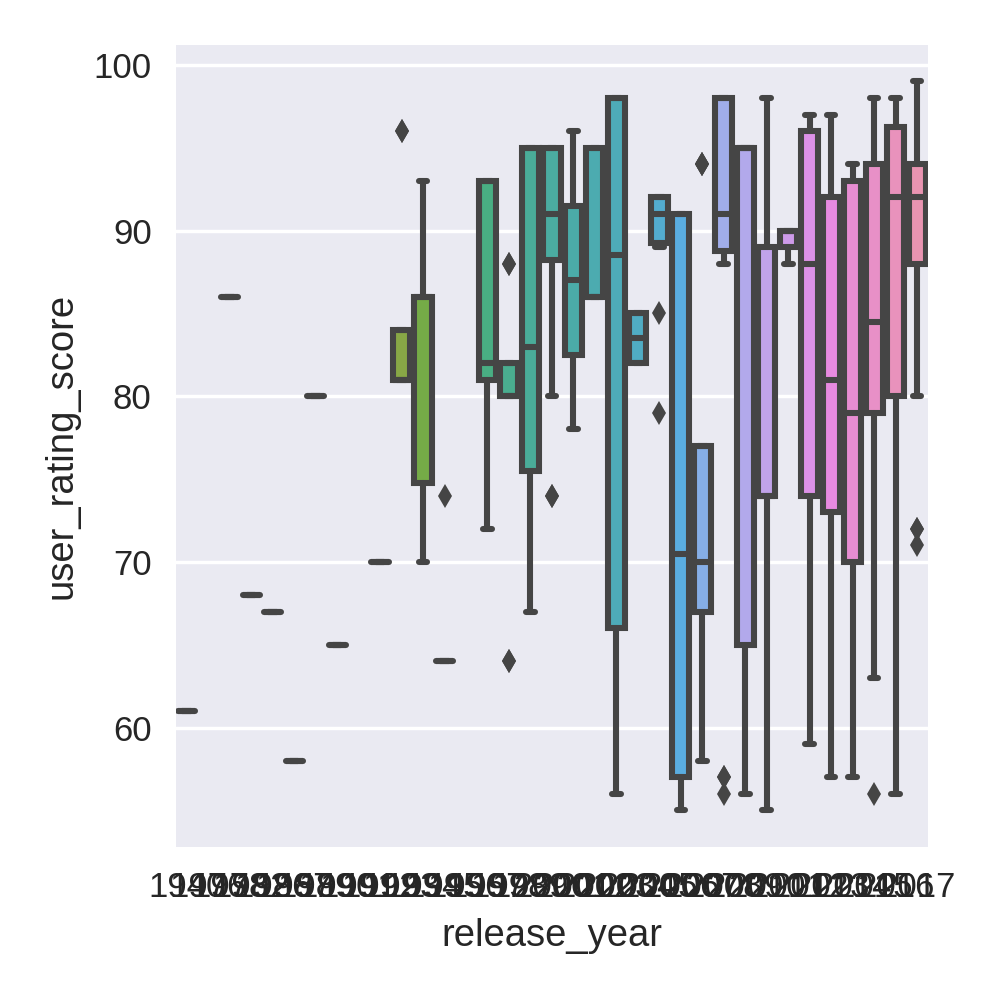

In [79]:
# Create boxplot  via factor plot
sns.factorplot(x="release_year", y="user_rating_score",data=df, kind="box")

Let's obtain a summary statistic, such as the mean and the compare agains the exmplanatory variables `release_year` and `rating`.

In [88]:
(df.groupby(['release_year','rating'])
   .median())

,,ratingdescription,user_rating_score,user_rating_size
release_year,rating,,,
1940,G,35,61.0,80
1978,PG,60,86.0,80
1982,PG,60,68.0,80
1986,G,35,67.0,80
1987,PG,60,58.0,80
1989,PG,60,80.0,80
1990,TV-Y7,41,65.0,80
1992,G,35,70.0,80
1993,G,35,96.0,80


In [89]:
df_median = (df.groupby(['release_year','rating'])
               .apply(lambda x:x.user_rating_score.median())) # behaves similar to summarise()
df_median.head() 

release_year  rating
1940          G         61.0
1978          PG        86.0
1982          PG        68.0
1986          G         67.0
1987          PG        58.0
dtype: float64

In [90]:
# To apply an arbitrary function the lambda function should return a new series
df1 = (df.groupby(['release_year','rating'])
               .apply(lambda x:pd.Series({'median_score':x.user_rating_score.median()})))
df1.head()

,,median_score
release_year,rating,
1940,G,61.0
1978,PG,86.0
1982,PG,68.0
1986,G,67.0
1987,PG,58.0


## `%>%`'ing in pandas 

- Method chaining means to call methods on an object one after another -- it is very popular in data science.

- Suppose we now want to compute an arbitrary function (e.g., the IQR) and the median along all possible values of `release_year` and `rating` for which the number of observations is positive.

In [187]:
# To apply an arbitrary function the lambda function should return a new series
df2 = (df.groupby(['release_year','rating']) # combine step
               .apply(lambda x:pd.Series({'n':x.user_rating_score.count(),
                                          'median':x.user_rating_score.median(),
                                          'q1':x.user_rating_score.quantile(0.25),
                                          'q3':x.user_rating_score.quantile(0.75)}))
               .query('n>0') # similar to filter() in dplyr
               .assign(IQR_score=lambda x: x.q3-x.q1) # similar to mutate() in dplyr
      .sort_index()) 
df2

,,median,n,q1,q3,IQR_score
release_year,rating,,,,,
1940,G,61.0,1.0,61.00,61.00,0.00
1978,PG,86.0,1.0,86.00,86.00,0.00
1982,PG,68.0,1.0,68.00,68.00,0.00
1986,G,67.0,1.0,67.00,67.00,0.00
1987,PG,58.0,1.0,58.00,58.00,0.00
1989,PG,80.0,1.0,80.00,80.00,0.00
1990,TV-Y7,65.0,1.0,65.00,65.00,0.00
1992,G,70.0,1.0,70.00,70.00,0.00
1993,G,96.0,1.0,96.00,96.00,0.00


## From wide to long format

- We now want to create a line plot `user_rating_score` against `release_year`of the median along with inter-quartile range (i.e., plotting q3 and q1) but identifying each line according to `rating`. 
- To do so, it is more convenient to convert our previous DataFrame object from wide to long format.

In [180]:
df3 = (pd.melt(df2.reset_index(), # notice that we have to add reset index
              col_level=0,
              id_vars=['release_year','rating'],
              value_vars=['median','q1','q3'],
              value_name='SummaryStatistic'))
df3.head()

,release_year,rating,variable,SummaryStatistic
0,1940,G,q2,61.0
1,1978,PG,q2,86.0
2,1982,PG,q2,68.0
3,1986,G,q2,67.0
4,1987,PG,q2,58.0


In [209]:
# Another less obscure option using stack()
df2.stack()

release_year  rating             
1940          G         median       61.0
                        n             1.0
                        q1           61.0
                        q3           61.0
                        IQR_score     0.0
1978          PG        median       86.0
                        n             1.0
                        q1           86.0
                        q3           86.0
                        IQR_score     0.0
1982          PG        median       68.0
                        n             1.0
                        q1           68.0
                        q3           68.0
                        IQR_score     0.0
1986          G         median       67.0
                        n             1.0
                        q1           67.0
                        q3           67.0
                        IQR_score     0.0
1987          PG        median       58.0
                        n             1.0
                        q1           58.0


In [ ]:
df2.stack().reset_index()

In [203]:
df3 = (df2.stack()
    .reset_index()
    .rename(index=str, columns={"level_2": "SummaryStatistic", 0: "value"}))
df3

,release_year,rating,SummaryStatistic,value
0,1940,G,median,61.0
1,1940,G,n,1.0
2,1940,G,q1,61.0
3,1940,G,q3,61.0
4,1940,G,IQR_score,0.0
5,1978,PG,median,86.0
6,1978,PG,n,1.0
7,1978,PG,q1,86.0
8,1978,PG,q3,86.0
9,1978,PG,IQR_score,0.0
